# Machine Learning LAB 3: CLUSTERING - K-means and linkage-based clustering

Course 2023/24: *M. Caligiuri*, *P. Talli*, *F. Lincetto*, *F. Chiariotti*, *P. Zanuttigh*

The notebook contains some simple tasks about **CLUSTERING**.

Complete all the **required code sections** and **answer to all the questions**.

### IMPORTANT for the evaluation score:

1. **Read carefully all cells** and **follow the instructions**.
2. **Re-run all the code from the beginning** to obtain the results for the final version of your notebook, since this is the way we will do it before evaluating your notebooks.
3. Make sure to fill the code in the appropriate places **without modifying the template**, otherwise you risk breaking later cells.
4. Please **submit the jupyter notebook file (.ipynb)**, do not submit python scripts (.py) or plain text files. **Make sure that it runs fine with the restat&run all command**.
5. **Answer the questions in the appropriate cells**, not in the ones where the question is presented.

## Image segmentation with k-means

In this laboratory we will use the k-means algorithm to cluster a dataset of 3D points. We will apply **K-means** to the problem of image compression and image segmentation. The main idea is to apply k-means to the colors of the pixels of an image to select the k most representative colors. Then, we will replace each pixel color with the closest representative color. This will allow us to reduce the number of colors in the image and compress it. A color is a vector of 3 values (R,G,B) that represent the amount of red, green and blue in the color; this implies that each pixel is a point in a 3D space.

In particular you are going to implement the k-means algorithm from scratch and to compare the results with the implementation already present in the sklearn library.

In the second part of the laboratory we will use a **linkage-based** clustering algorithm to cluster a dataset of 2D points and compare it with the results obtained with k-means.

---

## Preliminary step

Place your **name** and **ID number** (matricola) in the cell below. <br>
Also recall to **save the file as Surname_Name_LAB03.ipynb**, failure to do so will incur in a **lower grade**.

**Student name**: Martina Cacciola

**ID Number**: 2097476

---

## Import all the necessary Python libraries

In [1]:
%matplotlib inline  

import numpy as np
import typing as tp
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.cluster import KMeans, AgglomerativeClustering
from matplotlib import pyplot as plt

---

## Define the helper functions

In this section you will find some helper functions (some already implemented, some to be implemented by you) that will be used in the following sections.
1. `img_plot` -> function to plot an image with name and dimension as title,
2. `scatter_plot` -> function to plot a scatter plot of the data,
3. `scatter_plot_2d` -> function to plot a 2D scatter plot of the data,
4. `error_plot` -> function to plot the error of the k-means algorithm over the iterations,
5. `cluster_plot` -> function to plot the obtained clusters.

**DO NOT CHANGE THE PRE-WRITTEN CODE UNLESS OTHERWISE SPECIFIED**

In [2]:
def img_plot(img: np.ndarray, title: str = None) -> None:
    """
    Plot an image
    :param img: image to plot
    :param title: title of the plot
    """
    
    plt.figure()
    plt.imshow(img)
    plt.axis('off')
    if title is not None:
        plt.title(f'{title}: {img.shape}')
    plt.tight_layout()
    plt.show()
    plt.close()

In [3]:
def scatter_plot(data: np.ndarray, clusters: np.ndarray = None, centers: np.ndarray = None, title: str = None) -> None:
    """
    Plot a scatter plot of the data
    :param data: data to plot
    :param clusters: cluster labels
    :param centers: cluster centers
    :param title: title of the plot
    """
    
    fig = plt.figure()
    axis = fig.add_subplot(1, 1, 1, projection="3d")
    axis.set_xlabel("Red")
    axis.set_ylabel("Green")
    axis.set_zlabel("Blue", rotation=90, labelpad=-1)
    if title is not None:
        plt.title(title)
    if clusters is None:
        axis.scatter(data[:,0], data[:,1], data[:,2], marker="o", c=data, s=5)
    else:
        axis.scatter(data[:,0], data[:,1], data[:,2], marker="o", c=clusters, s=1, cmap='viridis', zorder=0, alpha=0.5 )
    if centers is not None:
        axis.scatter(centers[:,0], centers[:,1], centers[:,2], c='red', s=400, zorder=10)
    plt.tight_layout()
    plt.show()
    plt.close()

In [4]:
def scatter_plot_2d(x: np.ndarray, y: np.ndarray = None, centers: np.ndarray = None, title: str = None) -> None:
    """
    Plot a scatter plot of the data
    :param x: data to plot
    :param y: cluster labels
    :param centers: cluster centers
    :param title: title of the plot
    """

    fig = plt.figure()
    plt.scatter(x[:,0], x[:,1], c=y, marker="o", s=10, cmap='viridis')
    plt.scatter(centers[:,0], centers[:,1], c='black', s=200, alpha=0.5)
    if title is not None:
        plt.title(title)
    plt.tight_layout()
    plt.show()
    plt.close()

In [5]:
def error_plot(errors: np.ndarray, labels: np.ndarray = None) -> None:
    """
    Plot the errors over the iterations
    :param errors: errors to plot
    """
    
    if labels is None:
        plt.plot(errors[1:-1])
        plt.plot(errors[1:-1], 'ro')
    else:
        plt.plot(labels, errors)
        plt.plot(labels, errors, 'ro')
    plt.title('Error over iterations')
    plt.ylabel('Error')
    plt.xlabel('Iteration #')
    plt.grid()
    plt.tight_layout()
    plt.show()
    plt.close()

In [6]:
def cluster_plot(labels: np.ndarray, x: np.ndarray, title: str = None) -> None:
    """
    Plot the clusters
    :param labels: cluster labels
    :param x: data
    :param title: title of the plot
    """
    
    # Black removed and is used for noise instead.
    unique_labels = set(labels)
    colors = [plt.cm.Spectral(each)
            for each in np.linspace(0, 1, len(unique_labels))]
    for k, col in zip(unique_labels, colors):
        if k == -1:
            # Black used for noise.
            col = [0, 0, 0, 1]

        class_member_mask = (labels == k)

        xy = x[class_member_mask ]
        plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
                markeredgecolor='k', markersize=14)

        xy = x[class_member_mask ]
        plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
                markeredgecolor='k', markersize=6)

    if title is not None:
        plt.title(title)
    plt.tight_layout()
    plt.show()
    plt.close()

---

## A) K-means clustering

### TO DO (A.0)
    
**Set** the random **seed** using your **ID**. If you need to change it for testing add a constant explicitly, eg.: 1234567 + 1

In [7]:
# Fix your ID ("numero di matricola") and the seed for random generator
# as usual you can try different seeds by adding a constant to the number:
# ID = 1234567 + X
ID = 2097476  # insert your ID number here
np.random.seed(ID)

Load the provided images and display them (if you like you can experiment with other images)

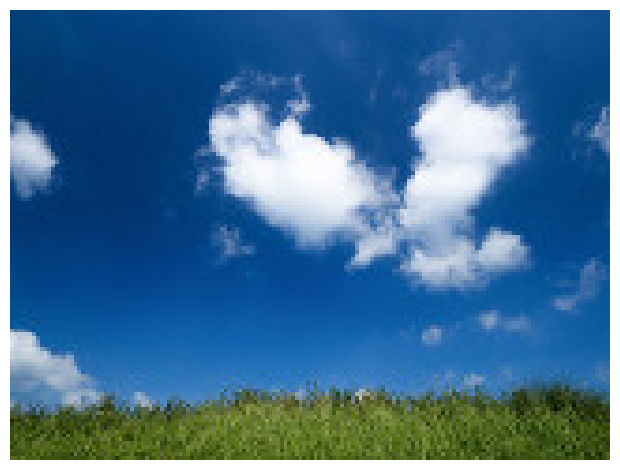

The shape of the image is (120, 160, 3)


The shape of the image is (281, 500, 3)


The shape of the image is (172, 256, 3)


In [8]:
# To load the images use the function plt.imread(<path_to_iamge>)
images = plt.imread('data/landscape.jpg'), plt.imread('data/reindeer.jpg'), plt.imread('data/santaclaus2.jpg')

# Plot the images with their shapes
# Suggestion: use the function img_plot()

for img in images:
    img_plot(img)
    print(f"The shape of the image is {img.shape}")

We are going to start by using the Santa Claus image.


In [9]:
# Reshape the data to a matrix of num_pixels x 3 
# (divide by 255 to have colors in [0 1] range for plotting functions of sklearn)

#select the image to use
img = images[2]

#reshape the image
num_pixels = img.shape[0] * img.shape[1]
data = img.reshape(num_pixels, 3)

#normalize the pixel values
data = data / 255.0

print(f"The shape of the image is {data.shape}")
print(f"The min pixel value is {data.min()}")
print(f"The max pixel value is {data.max()}")

The shape of the image is (44032, 3)
The min pixel value is 0.0
The max pixel value is 1.0


Plot the points in the 3-dimensional space with normalized intervals between 0 and 1 (corresponding to the three channels of the image, i.e. Red Green and Blue)

In [10]:
# Suggestion: use the function scatter_plot()

#3d space: each pixel (r,g,b) is a point 
scatter_plot(data)

### TO DO (A.1)
Implement the k-means algorithm manually (**do not use the kmeans function of sklearn and do not download implementations from other web sources**). The inputs to the function is the set of vectors to be clustered and the number of clusters. The output must contain the clusters barycenters, a vector associating each data point to the corresponding cluster and the error (value of the cost function) at each iteration.
Additionally, fix a maximum number of iterations of the k-means algorithm (e.g., 50).

Be careful about the initalization, you can use some random points from the training set, or get random values but ensure they are in the proper range. Poor initalizations can lead to the failure of the algorithm (in particular check that no cluster is initialized as empty, otherwise the algorithm can not update it).

In [11]:
def my_kmeans(points: np.ndarray, k: int, max_iters: int = 50) -> tp.Tuple[np.ndarray, np.ndarray, list]:
    """
    Perform K-means clustering
    :param points: data points
    :param k: number of clusters
    :param max_iters: maximum number of iterations
    """

    # Generate random centers
    # use sigma and mean to ensure it represent the whole data

    mean = np.mean(points, axis=0)
    sigma = np.std(points, axis=0)

    # Select k random centers (initialization)
    centroids = np.random.normal(loc=mean, scale=sigma, size=(k, points.shape[1]))

    prev_error = 100000
    error = [9999]
    
    # Iterate until the estimate of that center stays the same or max iteration are reached
    iters = 0
    while (error[iters] != prev_error) and iters < max_iters:

        # Measure the distance to every center
        dist = np.zeros((k, points.shape[0]))
        for i in range(k):
            dist[i] = np.sqrt(((points - centroids[i])**2).sum(axis=1))

        # Assign all training data to closest center
        clusters = np.argmin(dist, axis=0)
        
       # Calculate mean for every cluster and update the center
        for i in range(k):
            if points[clusters == i].size > 0:
                centroids[i] = points[clusters == i].mean(axis=0)
            else:
                # Reassign the centroid to a random point from the data
                centroids[i] = points[np.random.randint(points.shape[0]), :]
        
        # Update the error
        #error = cost function
        prev_error = error[iters]
        error.append(np.sum([np.sum((points[clusters==i] - centroids[i])**2) for i in range(k)]))

        
        # Update the iteration counter
        iters += 1

    return centroids, clusters, error

### TO DO (A.2)

Now try the function you developed on the Santaclaus image with three clusters (k=3). 

Then plot the data points in the 3-dimensional space, each point must be coloured based on the membership to one of the clusters. Additionally, plot the respective clusters centroids (use a different shape, size or color to highlight the centroids).

In [12]:
# Run your K-means function on the data
centroids, clusters, error = my_kmeans(data, 3, 50)

# Print the errors:
print(error)

# Plot the results
scatter_plot(data, clusters, centroids, title="Implemented K-means")

[9999, 6713.19153041738, 2259.8983486017314, 2079.8992266460177, 1904.2224240330606, 1610.687253351588, 1294.5161616097498, 1168.6091490776141, 1119.1153375598049, 1096.8526974159108, 1093.4675678027243, 1092.9648215156067, 1092.8948432719299, 1092.8816528132293, 1092.877269729635, 1092.8767238335545, 1092.876549748246, 1092.876549748246]


### TO DO (A.3) 
Plot the value of the error versus the number of iterations

In [13]:
# Suggestion: use the function error_plot()
error_plot(error)

### TO DO (A.4)
Now use the k-means function provided in sklearn. Pass to the function the number of clusters and use multiple random initializations (n_init parameter). Go to the documentation page for further details

In [14]:
# Define the K-means model
model = KMeans(n_clusters=3, init='random', max_iter=50)

# Fit the model to the data
model.fit(data)

# Get the cluster centers
print(model.cluster_centers_)

/Users/martinacacciola/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


[[0.77992885 0.77037787 0.76769853]
 [0.07869782 0.39466071 0.34312484]
 [0.39255442 0.05338858 0.06668254]]


Perform the same plot as above but with the output of the k-means function provided in sklearn.

In [15]:
#Plot the scatter plot
scatter_plot(data, model.labels_, model.cluster_centers_, title="Sklearn K-means")

### TO DO (A.Q1) [Answare the following] 

Compare the results obtained with your implementation and with k-means from sklearn. Do you observe any differences, *i.e.*, do the two plots match?

In [16]:
# Plot the centroids obtained from my implementation
plt.scatter(centroids[:, 0], centroids[:, 1], color='blue', label='My K-means', alpha=0.5)

# Plot the centroids obtained from sklearn's K-means
plt.scatter(model.cluster_centers_[:, 0], model.cluster_centers_[:, 1], color='red', label='Sklearn K-means', alpha=0.5)


plt.legend()
plt.show()

**ANSWER A.Q1:** In our case, the results obtained with the implementation `my_kmeans` and the k-means implementation from scikit-learn `model` perfectly coincide. This indicates that both implementations are producing the same clustering results. As can be seen from the plot above, the centroids are the same for both implementations.

### TO DO (A.5)

Now display the segmented image based on the two clusters found above with the k-means functions by sklearn.

In [17]:
# Reshape the data to the original image shape
#Extract the color values of the centers
colors = model.cluster_centers_[model.labels_]
segmented_img = colors.reshape(img.shape)

# Plot the original and segmented images
plt.figure(figsize=(10, 5))

# Original Image
plt.subplot(1, 2, 1)
plt.imshow(img)
plt.title('Original Image')

# Segmented Image
plt.subplot(1, 2, 2)
plt.imshow(segmented_img)
plt.title('Segmented Image (Sklearn K-means)')

plt.show()

Now display the segmented image based on the two clusters found above with the k-means functions implemented by yourselves.

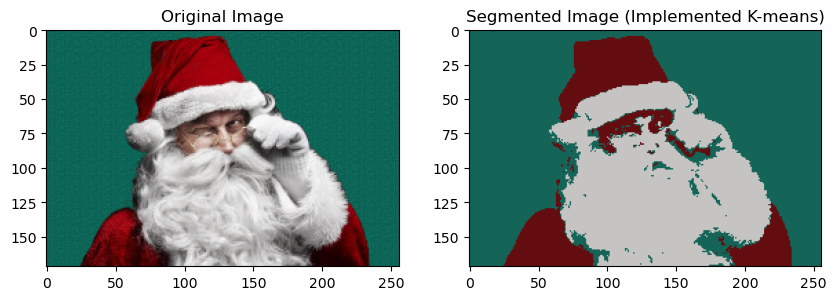

In [18]:
# Reshape the data to the original image shape
# Extract the color values of the centers
centroids, clusters, error = my_kmeans(data, k=3)
colors = centroids

segmented_img = colors[clusters].reshape(img.shape)

# Plot the original and segmented images
plt.figure(figsize=(10, 5))

# Original Image
plt.subplot(1, 2, 1)
plt.imshow(img)
plt.title('Original Image')

# Segmented Image
plt.subplot(1, 2, 2)
plt.imshow(segmented_img)
plt.title('Segmented Image (Implemented K-means)')

plt.show()

### TO DO (A.Q2) [Answare the following]

What do you observe? Do you think clustering is useful for image segmenation? And for image compression? Comment your answer.

**ANSWER A.Q2:** Above we can find the comparison between the original image and the segmented one, obtained by reducing the color range to three features. This leads to a stylized, almost cartoon-like appearance. We can observe the followings:

1. **Detail Loss**: Some details of the original image got lost in the segmentation process: for example, the nose and the glasses have become indistinguishible. In the case of the glasses that have an almost transparent appearence, the algorithm is associating them to the same 'block' of the face.

2. **Color Homogeneity**: Some areas of the image that were originally different but similar colors have now merged into the same color. In our case, the pink of the face is associated in the same block of the white beard, apart from some areas with more shadows (depicted in red).

3. **Highlighting of Main Features**: Despite the loss of detail, the main features or objects in the image can often still be distinguished, as K-means tends to preserve the boundaries between different colored regions. This permits to recognize without any problem the subject of the image, even if segmented.

Clustering is definitely useful for both image segmentation and image compression. It can be used to partition an image into multiple “clusters”, by grouping pixels that are similar to each other. Each cluster represents a particular class or object. This is useful in many applications, such as object detection and image recognition.

In case of image compression, the idea is to reduce the number of colors used in the image to a smaller set of representative colors. In this way, the image can be effectively compressed. The advantage is that it can significantly reduce the size of the image file, leading to few data to be stored.

However, it’s important to note that clustering methods may not always provide the best results for complex images, since they might cause loss of information and details. Their effectiveness depend on the specific task we are working on.

### TO DO (A.6)

Now load the landscape image (optional: try also with the reindeer image) and segment it using kmeans with k varying from 2 to 15 clusters. You can use the sklearn implementation.

Then plot the resulting data points in the 3-dimensional space, each point must be colored based on the cluster membership.

The shape of the image is (19200, 3)
The min pixel value is 0.0
The max pixel value is 1.0

K-means clustering with different values of K (2-15):


/Users/martinacacciola/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


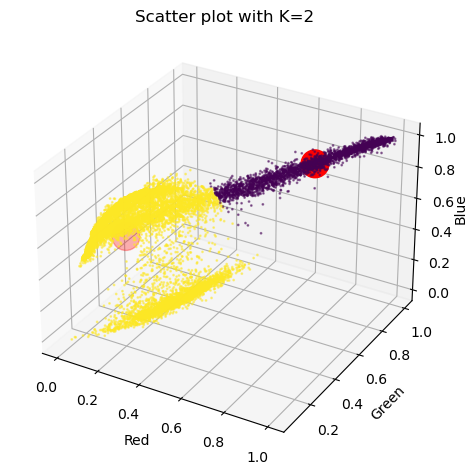

/Users/martinacacciola/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


/Users/martinacacciola/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


/Users/martinacacciola/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


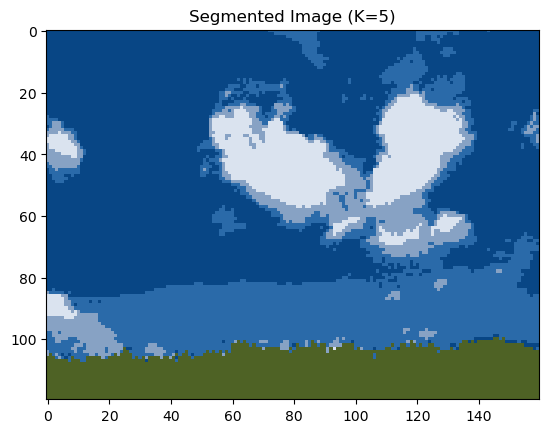

/Users/martinacacciola/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


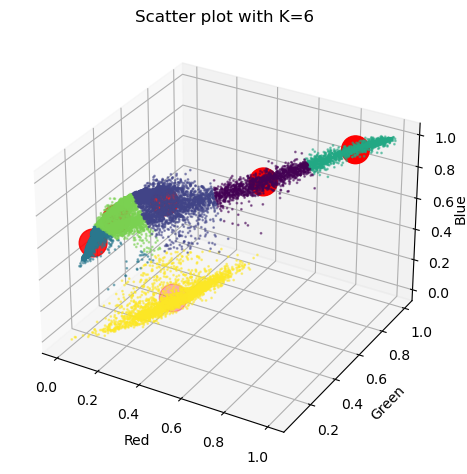

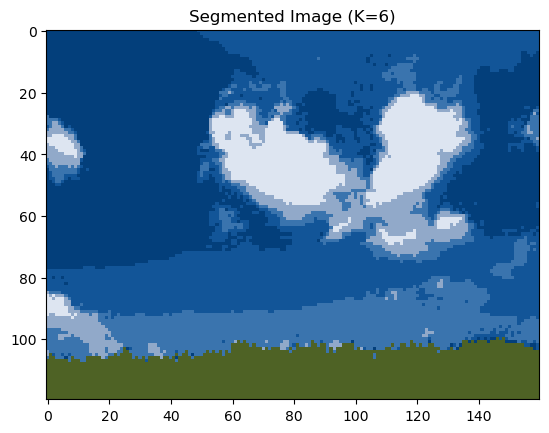

/Users/martinacacciola/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


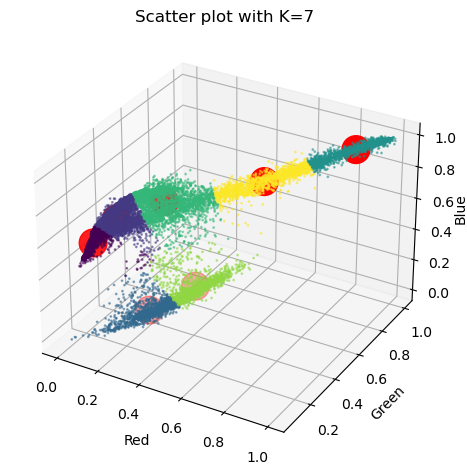

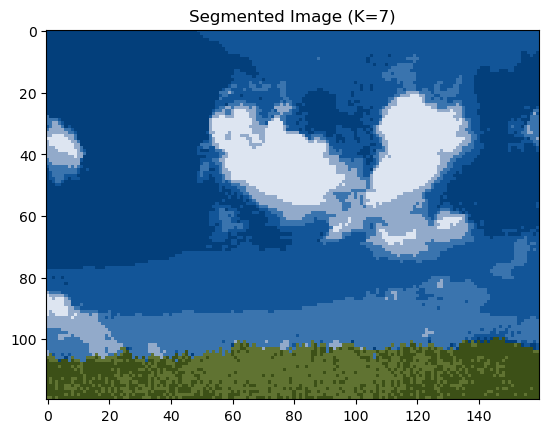

/Users/martinacacciola/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


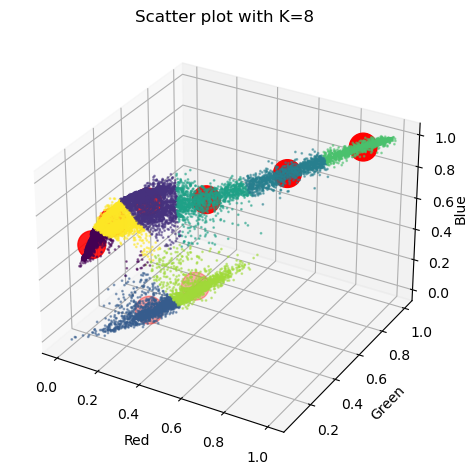

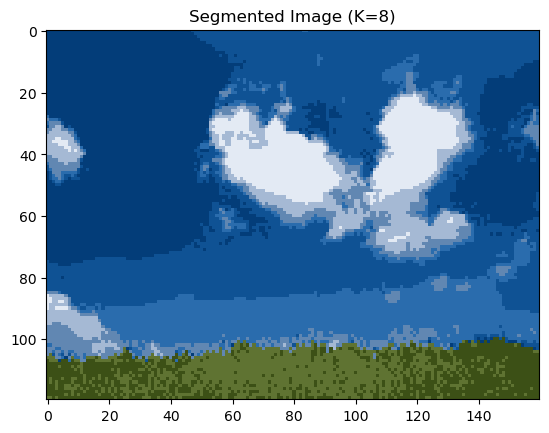

/Users/martinacacciola/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


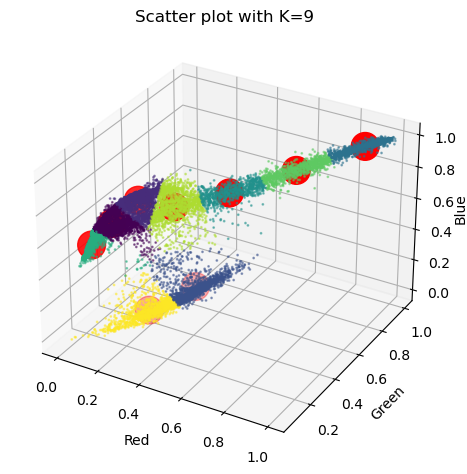

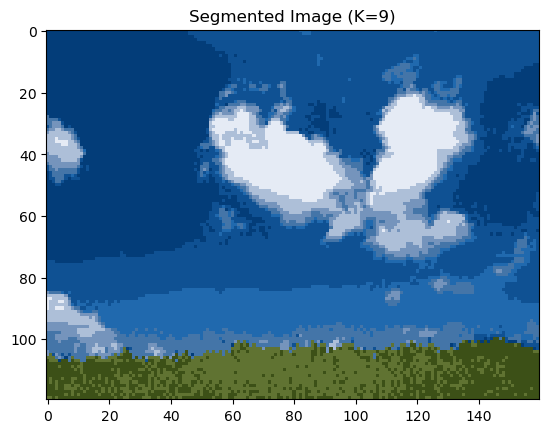

/Users/martinacacciola/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


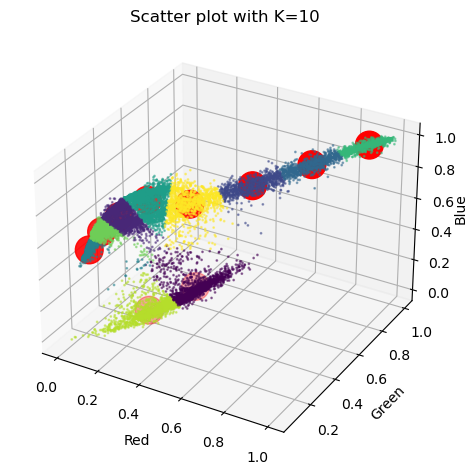

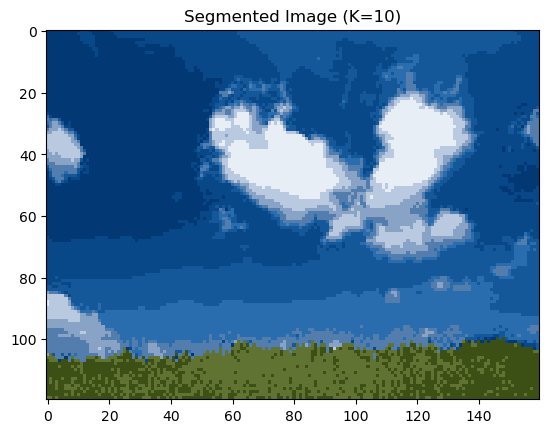

/Users/martinacacciola/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


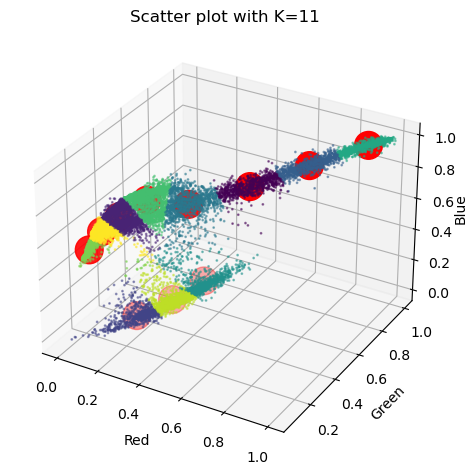

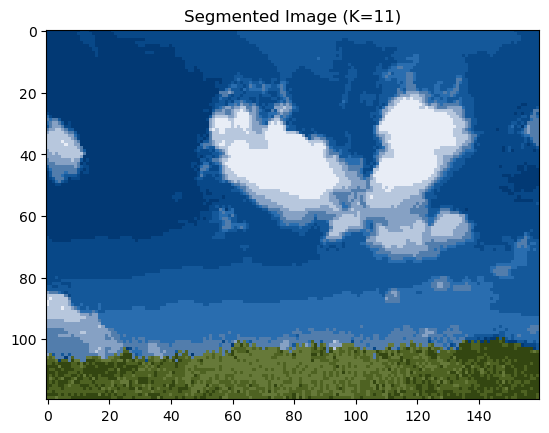

/Users/martinacacciola/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


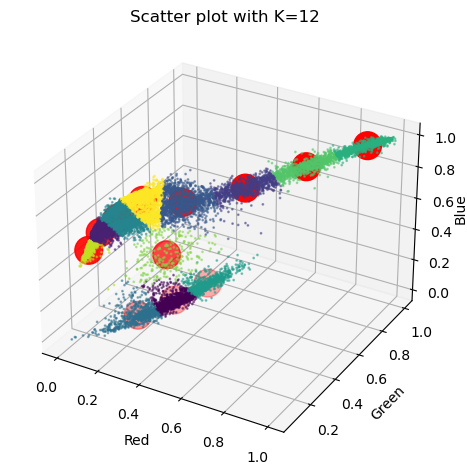

/Users/martinacacciola/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


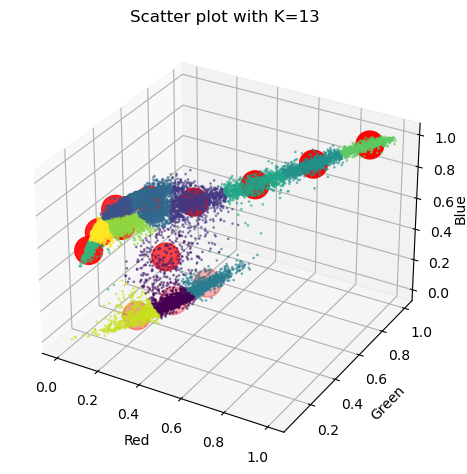

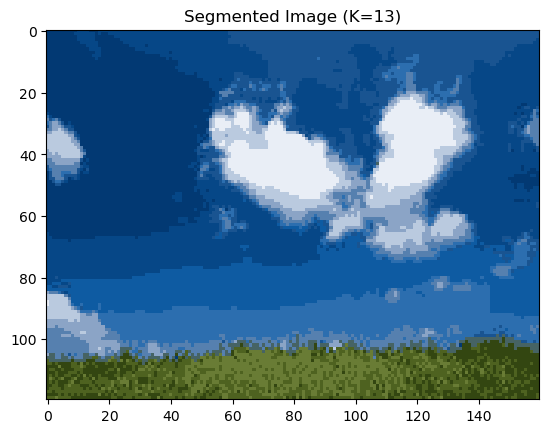

/Users/martinacacciola/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


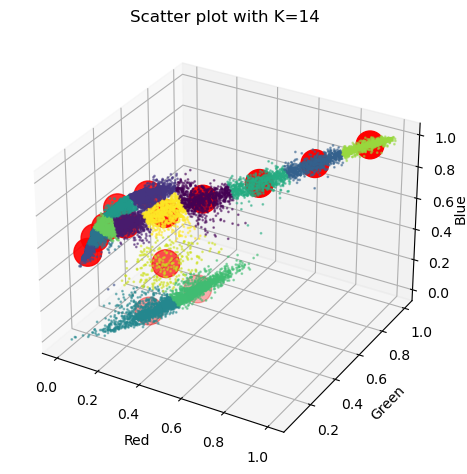

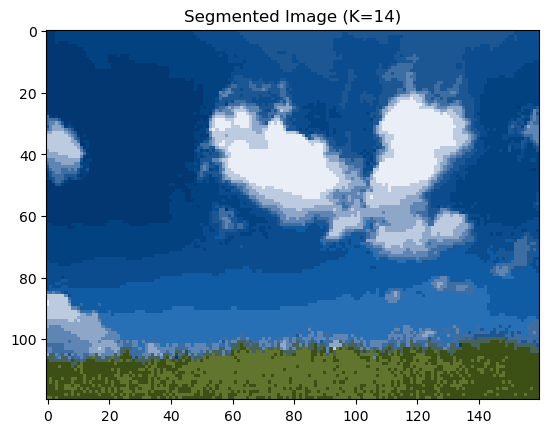

/Users/martinacacciola/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


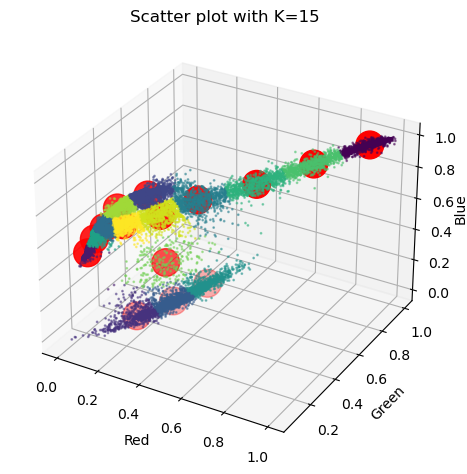

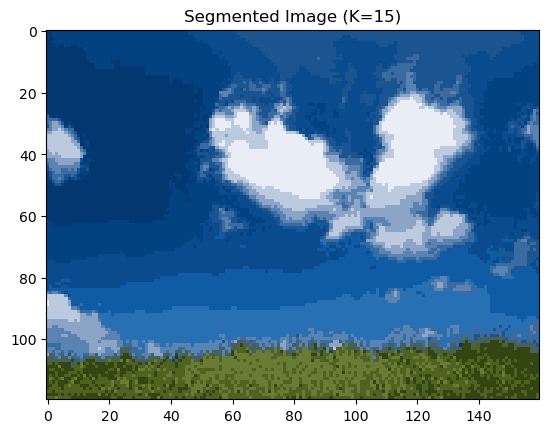

In [19]:
# Reshape the data to a matrix of total_num_pixels x 3

#select the image to use
img = images[0]

#reshape the image
num_pixels = img.shape[0] * img.shape[1]
data = img.reshape(num_pixels, 3)

#normalize the pixel values
data = data / 255.0

# Print the shape of the data and the min and max values of the pixels
print(f"The shape of the image is {data.shape}")
print(f"The min pixel value is {data.min()}")
print(f"The max pixel value is {data.max()}")

# Cycle over different values of K and plot the results for each value
print('\nK-means clustering with different values of K (2-15):')

inertia = list()
for k in range(2,16):
    # Define the K-means model
    model = KMeans(n_clusters=k, init='random', max_iter=50)

    # Fit the model to the data
    model.fit(data)

    # Get the cluster centers
    centroids = model.cluster_centers_

    # Extarct the color values of the centers
    colors = centroids

    # Reshape the data to the original image shape
    segmented_img = colors[model.labels_].reshape(img.shape)

    # Update the inertia
    inertia.append(model.inertia_)
    
    # Plot the scatter plot and the ricolored imag
    #plt.subplot(1, 2, 1)
    scatter_plot(data, model.labels_, centroids, title=f'Scatter plot with K={k}')
    plt.title(f'Scatter plot with K={k}')
    #plt.subplot(1, 2, 2)
    plt.imshow(segmented_img)
    plt.title(f'Segmented Image (K={k})')
    plt.show()
    
    # Plot the recolored image
    # ADD YOUR CODE HERE (remove the pass statement)
    #pass

The shape of the image is (140500, 3)
The min pixel value is 0.0
The max pixel value is 1.0

K-means clustering with different values of K (2-15):


/Users/martinacacciola/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


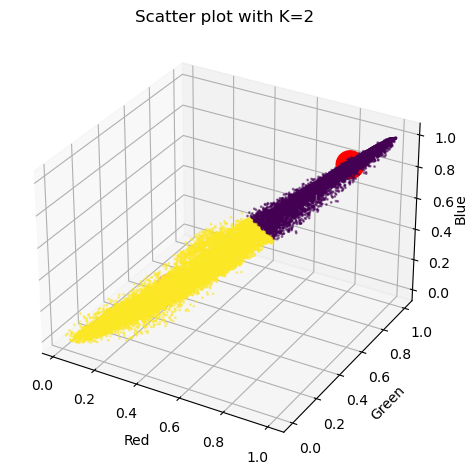

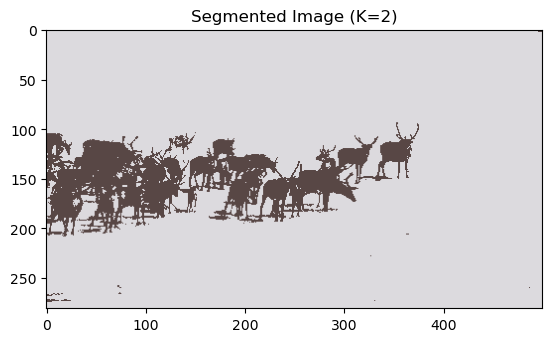

/Users/martinacacciola/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


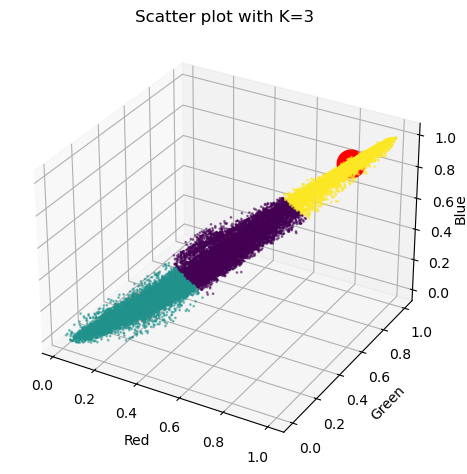

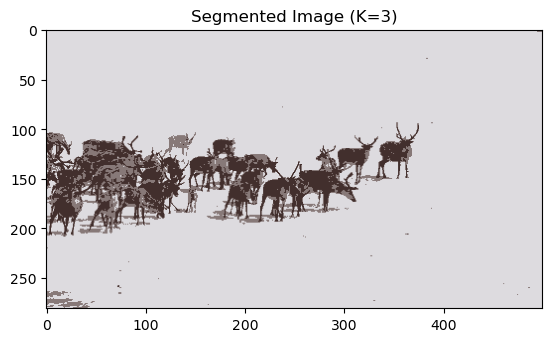

/Users/martinacacciola/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


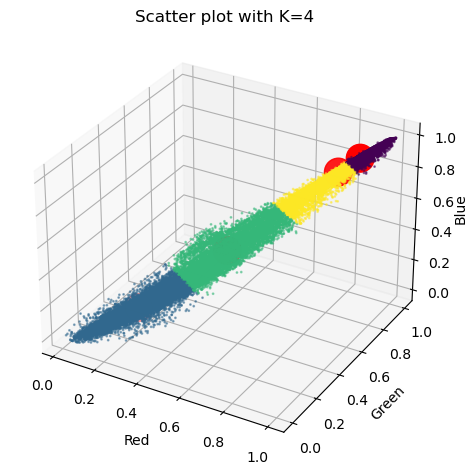

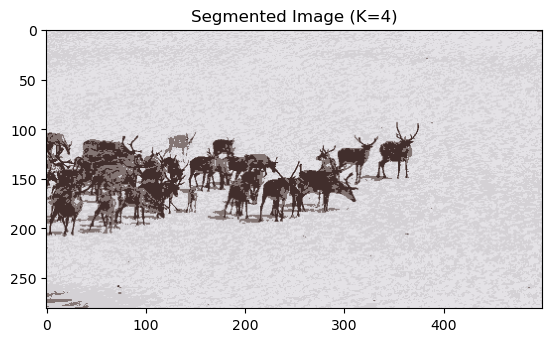

/Users/martinacacciola/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


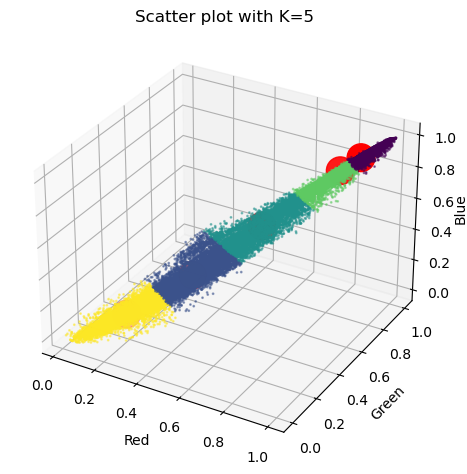

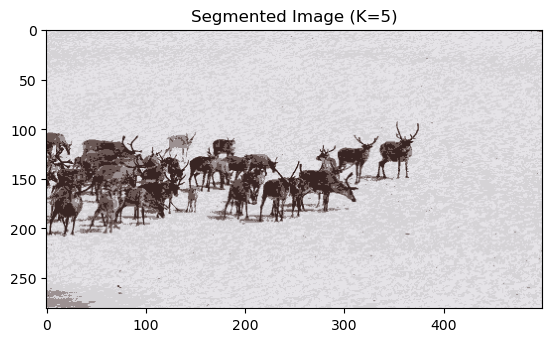

/Users/martinacacciola/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


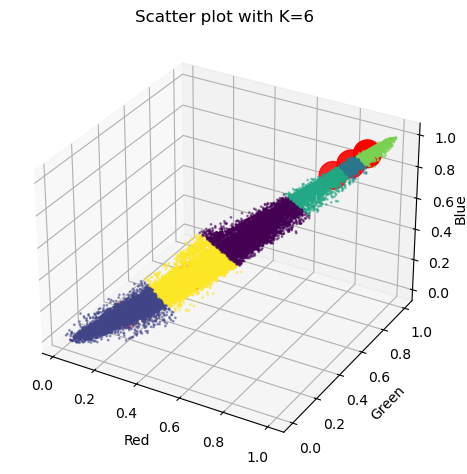

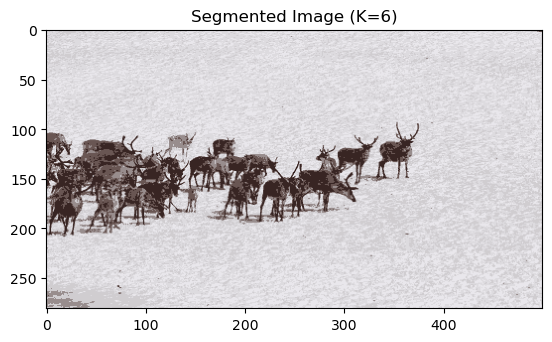

/Users/martinacacciola/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


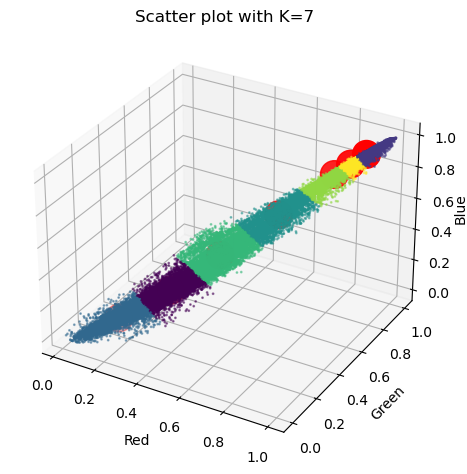

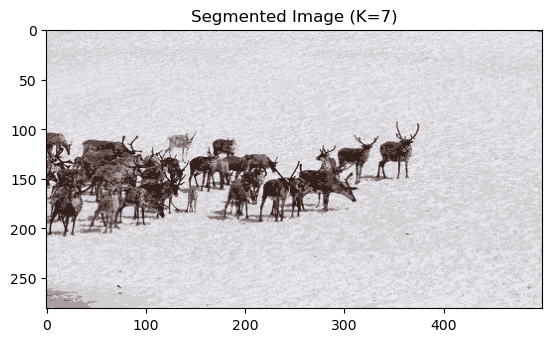

/Users/martinacacciola/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


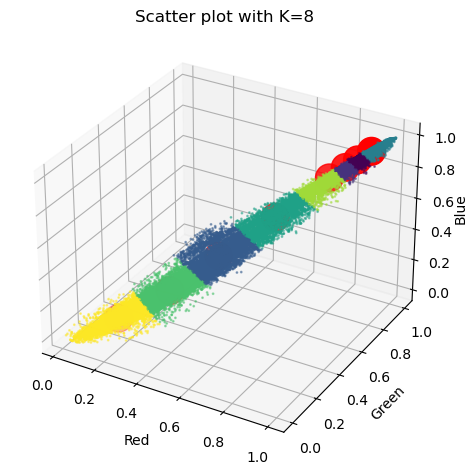

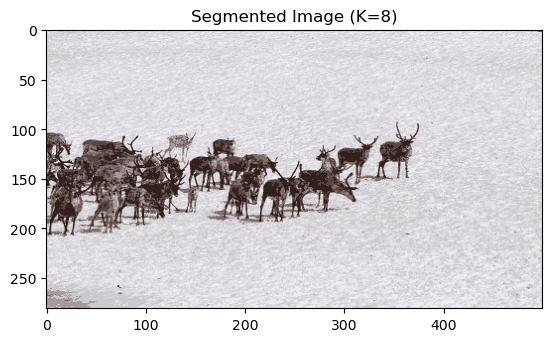

/Users/martinacacciola/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


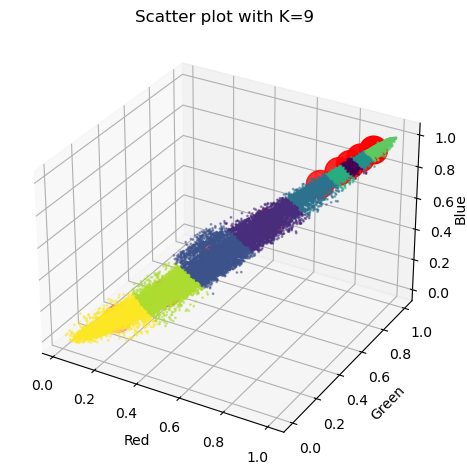

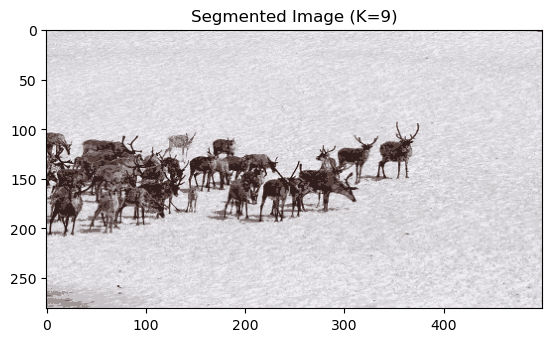

/Users/martinacacciola/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


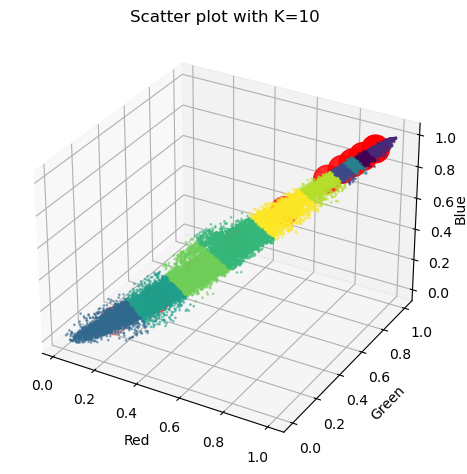

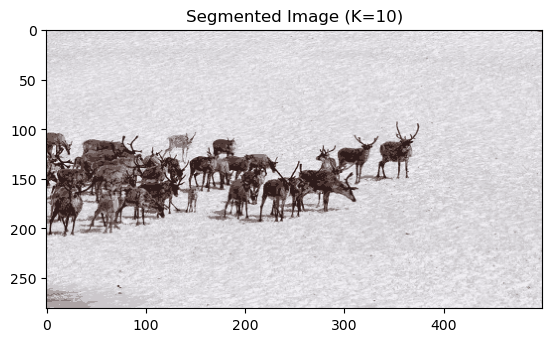

/Users/martinacacciola/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


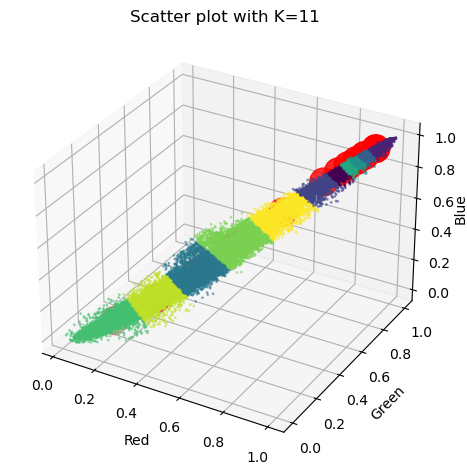

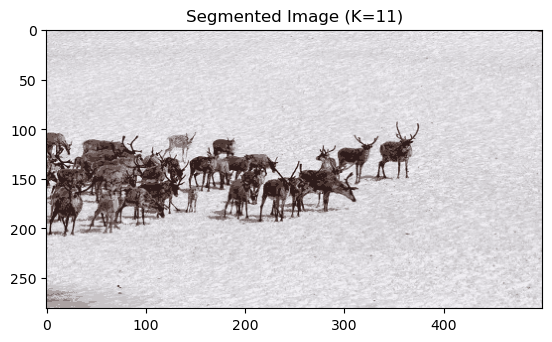

/Users/martinacacciola/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


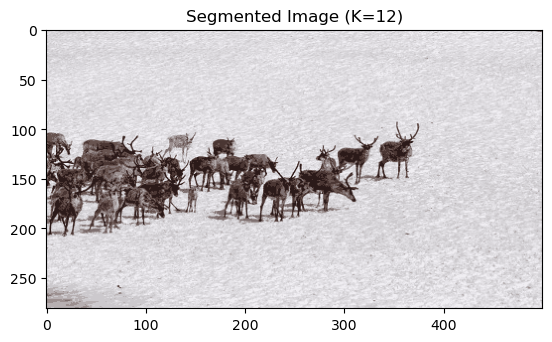

/Users/martinacacciola/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


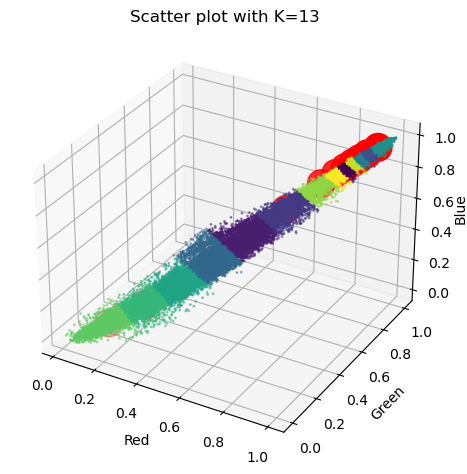

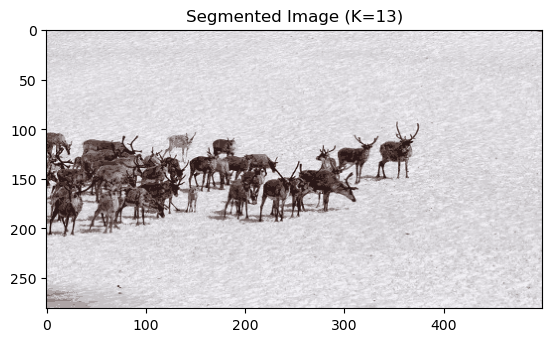

/Users/martinacacciola/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


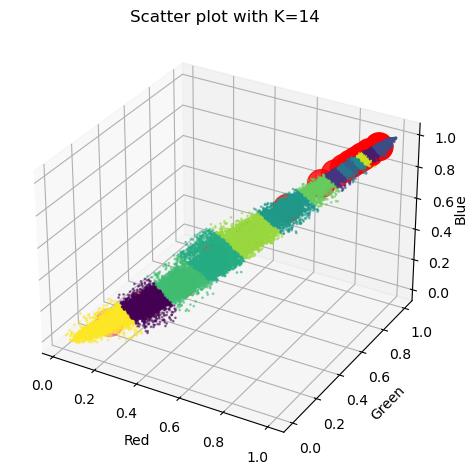

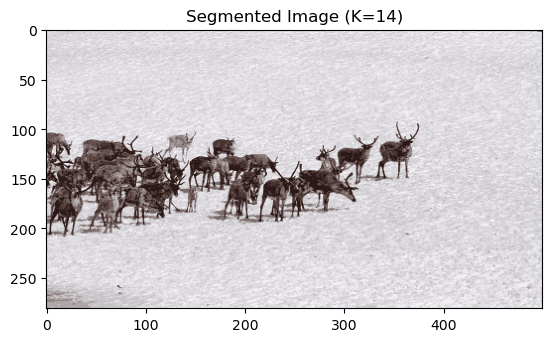

/Users/martinacacciola/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


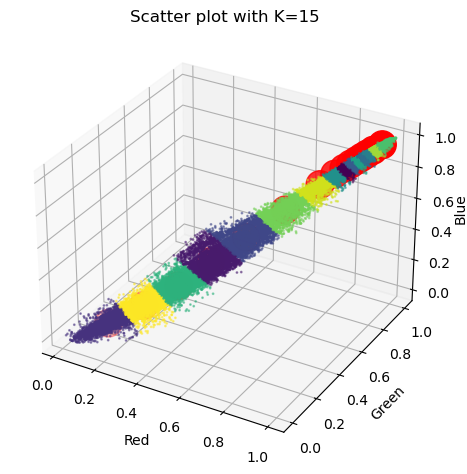

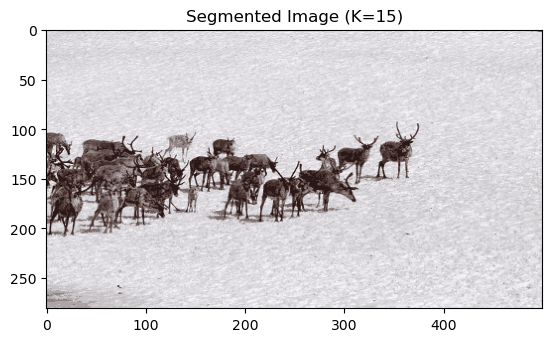

In [20]:
# Reshape the data to a matrix of total_num_pixels x 3

#select the image to use
img_reindeers = images[1]

#reshape the image
num_pixels = img_reindeers.shape[0] * img_reindeers.shape[1]
data = img_reindeers.reshape(num_pixels, 3)

#normalize the pixel values
data = data / 255.0

# Print the shape of the data and the min and max values of the pixels
print(f"The shape of the image is {data.shape}")
print(f"The min pixel value is {data.min()}")
print(f"The max pixel value is {data.max()}")

# Cycle over different values of K and plot the results for each value
print('\nK-means clustering with different values of K (2-15):')

inertia_reindeers = list()
for k in range(2,16):
    # Define the K-means model
    model = KMeans(n_clusters=k, init='random', max_iter=50)

    # Fit the model to the data
    model.fit(data)

    # Get the cluster centers
    centroids = model.cluster_centers_

    # Extarct the color values of the centers
    colors = centroids

    # Reshape the data to the original image shape
    segmented_img = colors[model.labels_].reshape(img_reindeers.shape)

    # Update the inertia
    inertia_reindeers.append(model.inertia_)
    
    # Plot the scatter plot and the ricolored imag
    #plt.subplot(1, 2, 1)
    scatter_plot(data, model.labels_, centroids, title=f'Scatter plot with K={k}')
    plt.title(f'Scatter plot with K={k}')
    #plt.subplot(1, 2, 2)
    plt.imshow(segmented_img)
    plt.title(f'Segmented Image (K={k})')
    plt.show()
    
    # Plot the recolored image
    # ADD YOUR CODE HERE (remove the pass statement)
    #pass

### TO DO (A.7)

Plot for different values of k (e.g. k between 2 and 15) the respective error of the kmeans algorithm 

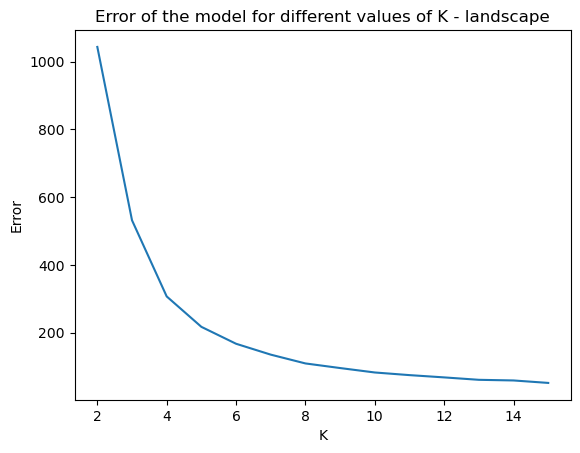

In [21]:
plt.plot(range(2,16), inertia)
plt.title('Error of the model for different values of K - landscape')
plt.xlabel('K')
plt.ylabel('Error')
plt.show()

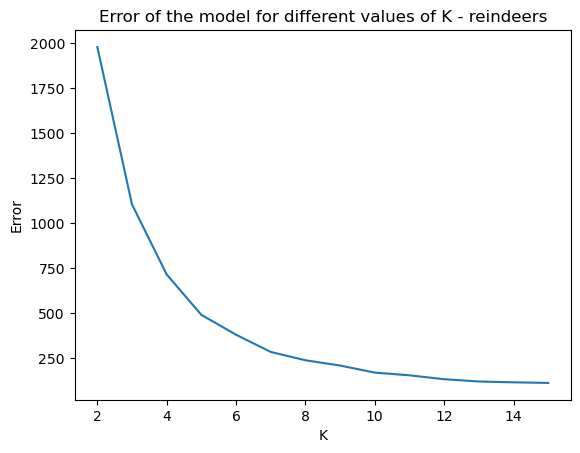

In [22]:
plt.plot(range(2,16), inertia_reindeers)
plt.title('Error of the model for different values of K - reindeers')
plt.xlabel('K')
plt.ylabel('Error')
plt.show()

### TO DO (AQ.3) [Answare the following]

Compare the results with different values of k, what do you observe? 

Analyze also the error, which one do you think is the optimal value of k?

Is there a single, clear answer?

**ANSWER A.Q3:** It can be observed that, by increasing the number of clusters `K`, the images in both cases gain more and more details, ending up for resembling almost perfectly the original image for `K` $\gtrsim$ 10. This is because each cluster will correspond to a different color feature of the original image, and considering a larger `K` adds more nuances to the pictures. 

By looking at the error evolution, a pronounced decrease in the number of errors is experienced between 0 and $\sim$ 10 clusters used in the implementation. After that, we see a steadier behaviour, meaning that the enhancement in the depicted features of the images is no longer significant.
This might suggest to consider around 10 clusters as the optimal value of `K`, but there is still no clear answer since it can vary depending on the specific requirements of the segmentation task and on the characteristics of the data.

---

## B) Linkage-based clustering

The second part of the assignment concern instead linkage-based clustering. We will use the AgglomerativeClustering module of sklearn. 

### TO DO (B.0)

Load the sample dataset located at `data/moon_data.npz`

In [23]:
# Load sample data
data = np.load('data/moon_data.npz')

# Extract data
x = data['X']
labels_true = data['labels_true']

### TO DO (B.1)

Now exploit the AgglomerativeClustering algorithm from sklearn on the provided sample data points. Use the "single" linkage type that correspond to the minimum distance criteria seen in the lectures and 2 clusters. Notice that the "single" option has been introduced recently in sklearn, if you get an error ensure you have a recent version of the library. Plot the resulting clustering.

In [24]:
# Compute Agglomerative Clustering
# Define the Agglomerative Clustering model
model = AgglomerativeClustering(n_clusters=2, affinity='euclidean', linkage='single')

# Fit the model to the data
model.fit(x)

# Compute the number of clusters in labels, ignoring noise if present.
#label = -1 to denote noise
n_clusters = len(set(model.labels_)) - (1 if -1 in model.labels_ else 0)

# Print the results
print('Estimated number of clusters: %d' % n_clusters)

Estimated number of clusters: 2


/Users/martinacacciola/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_agglomerative.py:1005: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(


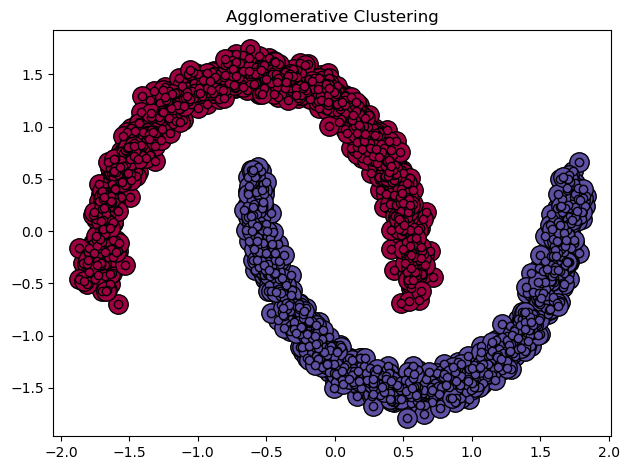

In [25]:
# Plot result 
# Sugestion: use the function cluster_plot()
cluster_plot(model.labels_, x, 'Agglomerative Clustering')

### TO DO (B.2)

Now try the KMeans with two clusters on the same dataset we used for the AgglomerativeClustering algorithm.

/Users/martinacacciola/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


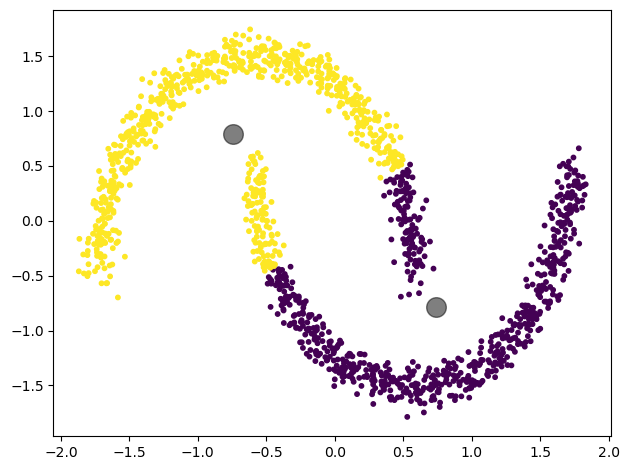

In [26]:
# Define the K-means model
kmodel = KMeans(n_clusters=2, init='random', max_iter=50)

# Fit the model to the data
kmodel.fit(x)

# Get the cluster centers
centers = kmodel.cluster_centers_

# Extarct the color values of the centers
colors = centers

# Plot the results
# Sugestion: use the function scatter_plot_2d()
scatter_plot_2d(x, kmodel.labels_, centers)

### TO DO (B.Q1) [Answare the following]

Compare the results of K-means and Agglomerative Clustering and explain what you observe and why?

**ANSWER B.Q1:** As can be seen, the Agglomerative Clustering is correctly reconstructing the distribution of the data, by dividing it into the two main clusters. The K-Means, instead, is clearly failing the task.
The different behaviour can attributed to some key differences between the two algorithms:

1. **Algorithm Structure**: K-means is a centroid-based algorithm that partitions the data into K distinct clusters. It assigns each data point to the cluster with the nearest mean value. Agglomerative Clustering, on the other hand, is a hierchical method, which initially treats each data point as a single cluster, and then successively merges the closest pairs of clusters until only one cluster (or K clusters) remain.

2. **Sensitivity to Initial Conditions**: K-means is sensitive to the initial placement of the centroids, which can lead to different results if we are not lucky with the inizialization. Agglomerative Clustering does not have this issue, as it does not rely on initial values.

3. **Cluster Shape**: K-means tends to work well when clusters are spherical or hyper-spherical. If clusters have irregular shapes, K-means might not perform as well. Agglomerative Clustering does not make assumptions about the shape of clusters and can therefore handle clusters of various shapes.

For all the reasons above, it can be explained why the Agglomerative Clustering is working effectively on our dataset, since it might handle better the shape of the data and is not influenced by a possibly bad inizialization.


---